In [ ]:
# Importing necessary libraries for EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv('/content/spam_ham_dataset.csv')
data.head(10)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
8,2641,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [ ]:
data.shape

(5171, 4)

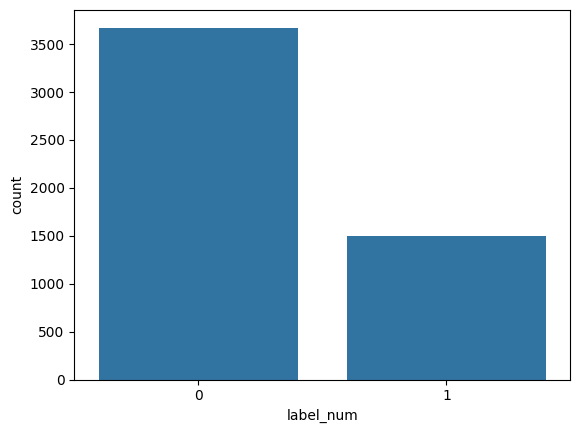

In [ ]:
sns.countplot(x='label_num', data=data)
plt.show()

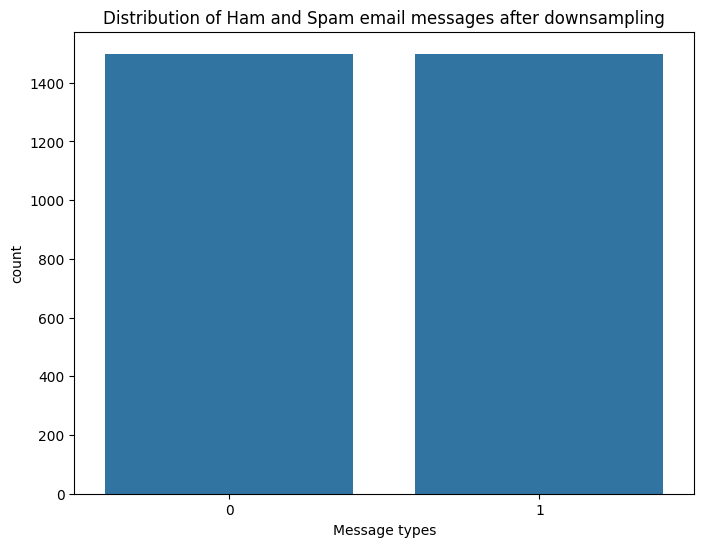

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Downsampling to balance the dataset
ham_msg = data[data.label_num == 0]
spam_msg = data[data.label_num == 1]

# Check if both ham_msg and spam_msg are not empty
if not ham_msg.empty and not spam_msg.empty:
    ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

    # Plotting the counts of down sampled dataset
    balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)
    plt.figure(figsize=(8, 6))
    sns.countplot(data=balanced_data, x='label_num')
    plt.title('Distribution of Ham and Spam email messages after downsampling')
    plt.xlabel('Message types')
    plt.show()
else:
    print("Either ham_msg or spam_msg is empty. Please check your data filtering.")


In [ ]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()


,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [ ]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [ ]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


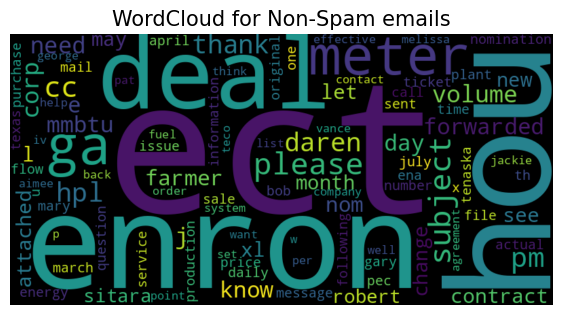

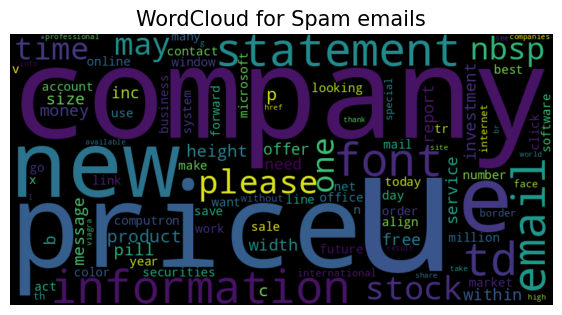

In [ ]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['label_num'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label_num'] == 1], typ='Spam')


In [ ]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['label_num'],
													test_size = 0.2,
													random_state = 42)


In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')


In [ ]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32,
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1274912   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1278625 (4.88 MB)
Trainable params: 1278625 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [ ]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [ ]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
75/75 [==============================] - 7s 59ms/step - loss: 0.6899 - accuracy: 0.5467 - val_loss: 0.6648 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 6s 76ms/step - loss: 0.3191 - accuracy: 0.8816 - val_loss: 0.2305 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 4s 53ms/step - loss: 0.1543 - accuracy: 0.9587 - val_loss: 0.1901 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 4s 51ms/step - loss: 0.1717 - accuracy: 0.9608 - val_loss: 0.1150 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 5s 67ms/step - loss: 0.0727 - accuracy: 0.9862 - val_loss: 0.1409 - val_accuracy: 0.9683 - lr: 0.0010
Epoch 6/20
75/75 [==============================] - 4s 52ms/step - loss: 0.0539 - accuracy: 0.9904 - val_loss: 0.1847 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 7/20
75/75 [==============================] - 4s 52ms/step - loss: 0.0

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


19/19 [==============================] - 0s 10ms/step - loss: 0.1253 - accuracy: 0.9733
Test Loss : 0.1253330558538437
Test Accuracy : 0.9733333587646484


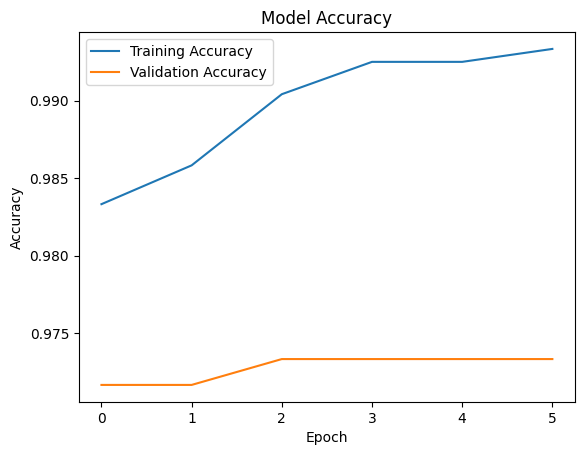

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
